In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

data= pd.read_csv(r'C:/Users/Administrator/Desktop/EURUSD30.csv')
# a_zero=pd.series(np.zeros(1))
# data['close+1']=data.close.iloc[1:-1,:]
# data['close+1']=a_zero.append(data['close+1'])
data['diff']= data.close.diff() #差 
handle=data['diff'].iloc[1:] #本次需要处理的数据
sma_flag=0 #flag=1时调用sma相关方法
handle

1        -356.0
2         -30.0
3        3262.0
4        -703.0
5        1483.0
          ...  
17943     -76.0
17944      34.0
17945     -35.0
17946    -377.0
17947     192.0
Name: diff, Length: 17947, dtype: float64

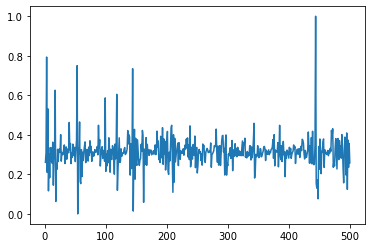

In [2]:
c_data=handle.head(500)
r_c_data=handle.head(500)
dmax=c_data.max()
dmin=c_data.min()
c_data=(c_data-c_data.min())/(c_data.max()-c_data.min())

Lk_back=5

plt.plot(c_data,  label='close_normalised')

In [28]:
# In[2]:
def SMAcompute(dataset,look_back):
#     window=dataset[:look_back]
    dataset=np.array(dataset)
    rt=[]
    for i in range(len(dataset)): 
        if i < look_back:
            rt.append(dataset[:i+1].mean())
        else :
#             np.append(window,dataset[i])
            rt.append(dataset[(i-look_back+1):i+1].mean())
    return np.array(rt)

def SMArevive(sma,raw,look_back):
    ls=[]
    for i in range(len(sma)):
        if i==0 :
            ls.append(sma[0])
        elif i<look_back:
            ls.append(sma[i]*(i+1)-raw[0:i].sum())
        else :
            ls.append(sma[i]*look_back-raw[(i-look_back+1):i].sum())
    return np.array(ls)

def renormal(dataset_normalized,dmax,dmin):
#     dmax=dataset_real.max()
#     dmin=dataset_real.min()
    return dataset_normalized*(dmax-dmin)+dmin

In [4]:
# In[3]:


# plt.figure(figsize=(99,99))
# plt.plot(SMAcompute(c_data,200),'r',label='sma')
# plt.plot(c_data,'b',label='raw')
if sma_flag : 
    #巨量bug警告
    SMArevive(SMAcompute(c_data,200),c_data,200)-c_data
    sma_close=SMAcompute(r_c_data,200)
    scmax=sma_close.max()
    scmin=sma_close.min()
    sma_close_norm=(sma_close-scmin)/(scmax-scmin)
    # plt.plot(sma_close)
    plt.plot(sma_close_norm)
    data_input=sma_close_norm
else :
    data_input=c_data
data_input

1      0.260895
2      0.308893
3      0.793581
4      0.209806
5      0.531655
         ...   
496    0.124264
497    0.373969
498    0.235424
499    0.356596
500    0.258245
Name: diff, Length: 500, dtype: float64

In [5]:
# plt.plot(renormal(SMArevive(SMAcompute(c_data,200),200),dmin,dmax)-renormal(c_data,dmin,dmax))


# In[4]:


def creat_dataset(dataset,look_back):
    data_x = []
    data_y = []
    for i in range(len(dataset)-look_back):
        data_x.append(dataset[i:i+look_back])
        data_y.append(dataset[i+look_back])
    return np.asarray(data_x), np.asarray(data_y) #转为ndarray数据


# In[5]:


Input_dim=1
Output_dim=1
Hidden_size=6
Batch_size=2000


# In[6]:


class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.lstm = nn.LSTM(Lk_back,6,2)#输入数据LK_back个特征维度，6个隐藏层维度，2个LSTM串联，第二个LSTM接收第一个的计算结果
        self.out = nn.Linear(6,1)#线性拟合，接收数据的维度为6，输出数据的维度为1
    def forward(self,x):
        x1,_ = self.lstm(x)
        a,b,c = x1.shape
        out = self.out(x1.view(-1,c)) #因为线性层输入的是个二维数据，所以此处应该将lstm输出的三维数据x1调整成二维数据，最后的特征维度不能变
        out1 = out.view(a,b,-1) #因为是循环神经网络，最后的时候要把二维的out调整成三维数据，下一次循环使用
        return out1
    

In [6]:
# In[7]:


rnn = RNN()

#参数寻优，计算损失函数

optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss()


# In[8]:


dataX, dataY = creat_dataset(data_input,Lk_back)
train_size = int(len(dataX)*0.7)

x_train = dataX[:train_size] #训练数据
y_train = dataY[:train_size] #训练数据目标值
x_test=dataX[train_size:]
y_test=dataY[train_size:]
x_train

array([[0.26089517, 0.30889282, 0.79358068, 0.20980565, 0.53165489],
       [0.30889282, 0.79358068, 0.20980565, 0.53165489, 0.11675501],
       [0.79358068, 0.20980565, 0.53165489, 0.11675501, 0.30315077],
       ...,
       [0.1815371 , 0.20951119, 0.30153121, 0.28931095, 0.29122497],
       [0.20951119, 0.30153121, 0.28931095, 0.29122497, 0.34496466],
       [0.30153121, 0.28931095, 0.29122497, 0.34496466, 0.30815665]])

In [9]:
def tensorfy_array(arr_x,arr_y):
    R_x = arr_x.reshape(-1, 1, Lk_back) #将训练数据调整成pytorch中lstm算法的输入维度
    R_y = arr_y.reshape(-1, 1, 1) #将目标值调整成pytorch中lstm算法的输出维度
    R_x = torch.tensor(R_x,dtype=torch.float32)
    R_y = torch.tensor(R_y,dtype=torch.float32)
    return R_x,R_y

In [10]:
# In[9]:
# x_train = x_train.reshape(-1, 1, Lk_back) #将训练数据调整成pytorch中lstm算法的输入维度
# y_train = y_train.reshape(-1, 1, 1)  #将目标值调整成pytorch中lstm算法的输出维度
# x_train = torch.tensor(x_train,dtype=torch.float32)
# y_train = torch.tensor(y_train,dtype=torch.float32)

x_train,y_train = tensorfy_array(x_train,y_train)
x_test,y_test= tensorfy_array(x_test,y_test)

# In[10]:

# if(torch.cuda.is_available()):
#     x_train=x_train.cuda()
#     y_train=y_train.cuda()
#     rnn=rnn.cuda()


# In[ ]:

for i in range(60):
    
    out = rnn(x_train)
    loss = loss_func(out,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1)%1==0:
        print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))


# In[ ]:

Epoch:1, Loss:0.01196
Epoch:2, Loss:0.00617
Epoch:3, Loss:0.00907
Epoch:4, Loss:0.00779
Epoch:5, Loss:0.00619
Epoch:6, Loss:0.00607
Epoch:7, Loss:0.00674
Epoch:8, Loss:0.00700
Epoch:9, Loss:0.00665
Epoch:10, Loss:0.00617
Epoch:11, Loss:0.00595
Epoch:12, Loss:0.00606
Epoch:13, Loss:0.00629
Epoch:14, Loss:0.00641
Epoch:15, Loss:0.00633
Epoch:16, Loss:0.00614
Epoch:17, Loss:0.00598
Epoch:18, Loss:0.00594
Epoch:19, Loss:0.00601
Epoch:20, Loss:0.00610
Epoch:21, Loss:0.00615
Epoch:22, Loss:0.00611
Epoch:23, Loss:0.00603
Epoch:24, Loss:0.00595
Epoch:25, Loss:0.00593
Epoch:26, Loss:0.00596
Epoch:27, Loss:0.00600
Epoch:28, Loss:0.00603
Epoch:29, Loss:0.00602
Epoch:30, Loss:0.00598
Epoch:31, Loss:0.00594
Epoch:32, Loss:0.00592
Epoch:33, Loss:0.00593
Epoch:34, Loss:0.00596
Epoch:35, Loss:0.00597
Epoch:36, Loss:0.00596
Epoch:37, Loss:0.00594
Epoch:38, Loss:0.00592
Epoch:39, Loss:0.00591
Epoch:40, Loss:0.00592
Epoch:41, Loss:0.00593
Epoch:42, Loss:0.00593
Epoch:43, Loss:0.00592
Epoch:44, Loss:0.005

In [12]:
pred_train = rnn(x_train)
pred_train = pred_train.view(-1).data.numpy()
pred_test = rnn(x_test)
pred_test = pred_test.view(-1).data.numpy()

In [25]:
np.array(y_test.view(-1)).shape

(149,)

In [26]:
pred_test.shape

(149,)

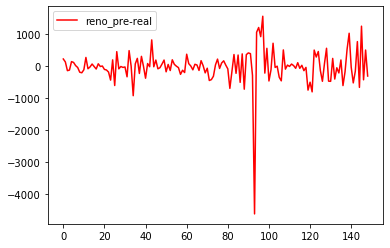

MSR= 298060.88
R^2= 0.02223304072659027


In [32]:
#测试集的结果
reno_pred=renormal(pred_test,dmax,dmin)
reno_real=renormal(np.array(y_test.view(-1)),dmax,dmin)

if sma_flag:
    pred=renormal(SMArevive(pred_test,c_data[:train_size],200),scmax,scmin)
    real=renormal(SMArevive(dataY[:train_size],c_data[:train_size],200),scmax,scmin)
else:
    pred=reno_pred
    real=reno_real


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def show_difference(pred,real):
    # re_dataY=dataY[:train_size]
    # plt.plot( pred_train-dataY[:train_size], 'b', label='pre-real')
    plt.plot(pred-real, 'r', label='reno_pre-real')
    plt.legend(loc='best')
    plt.show()
    print("MSR=",mean_squared_error(real,pred))
    print("R^2=",r2_score(real,pred))
    
show_difference(pred,real)

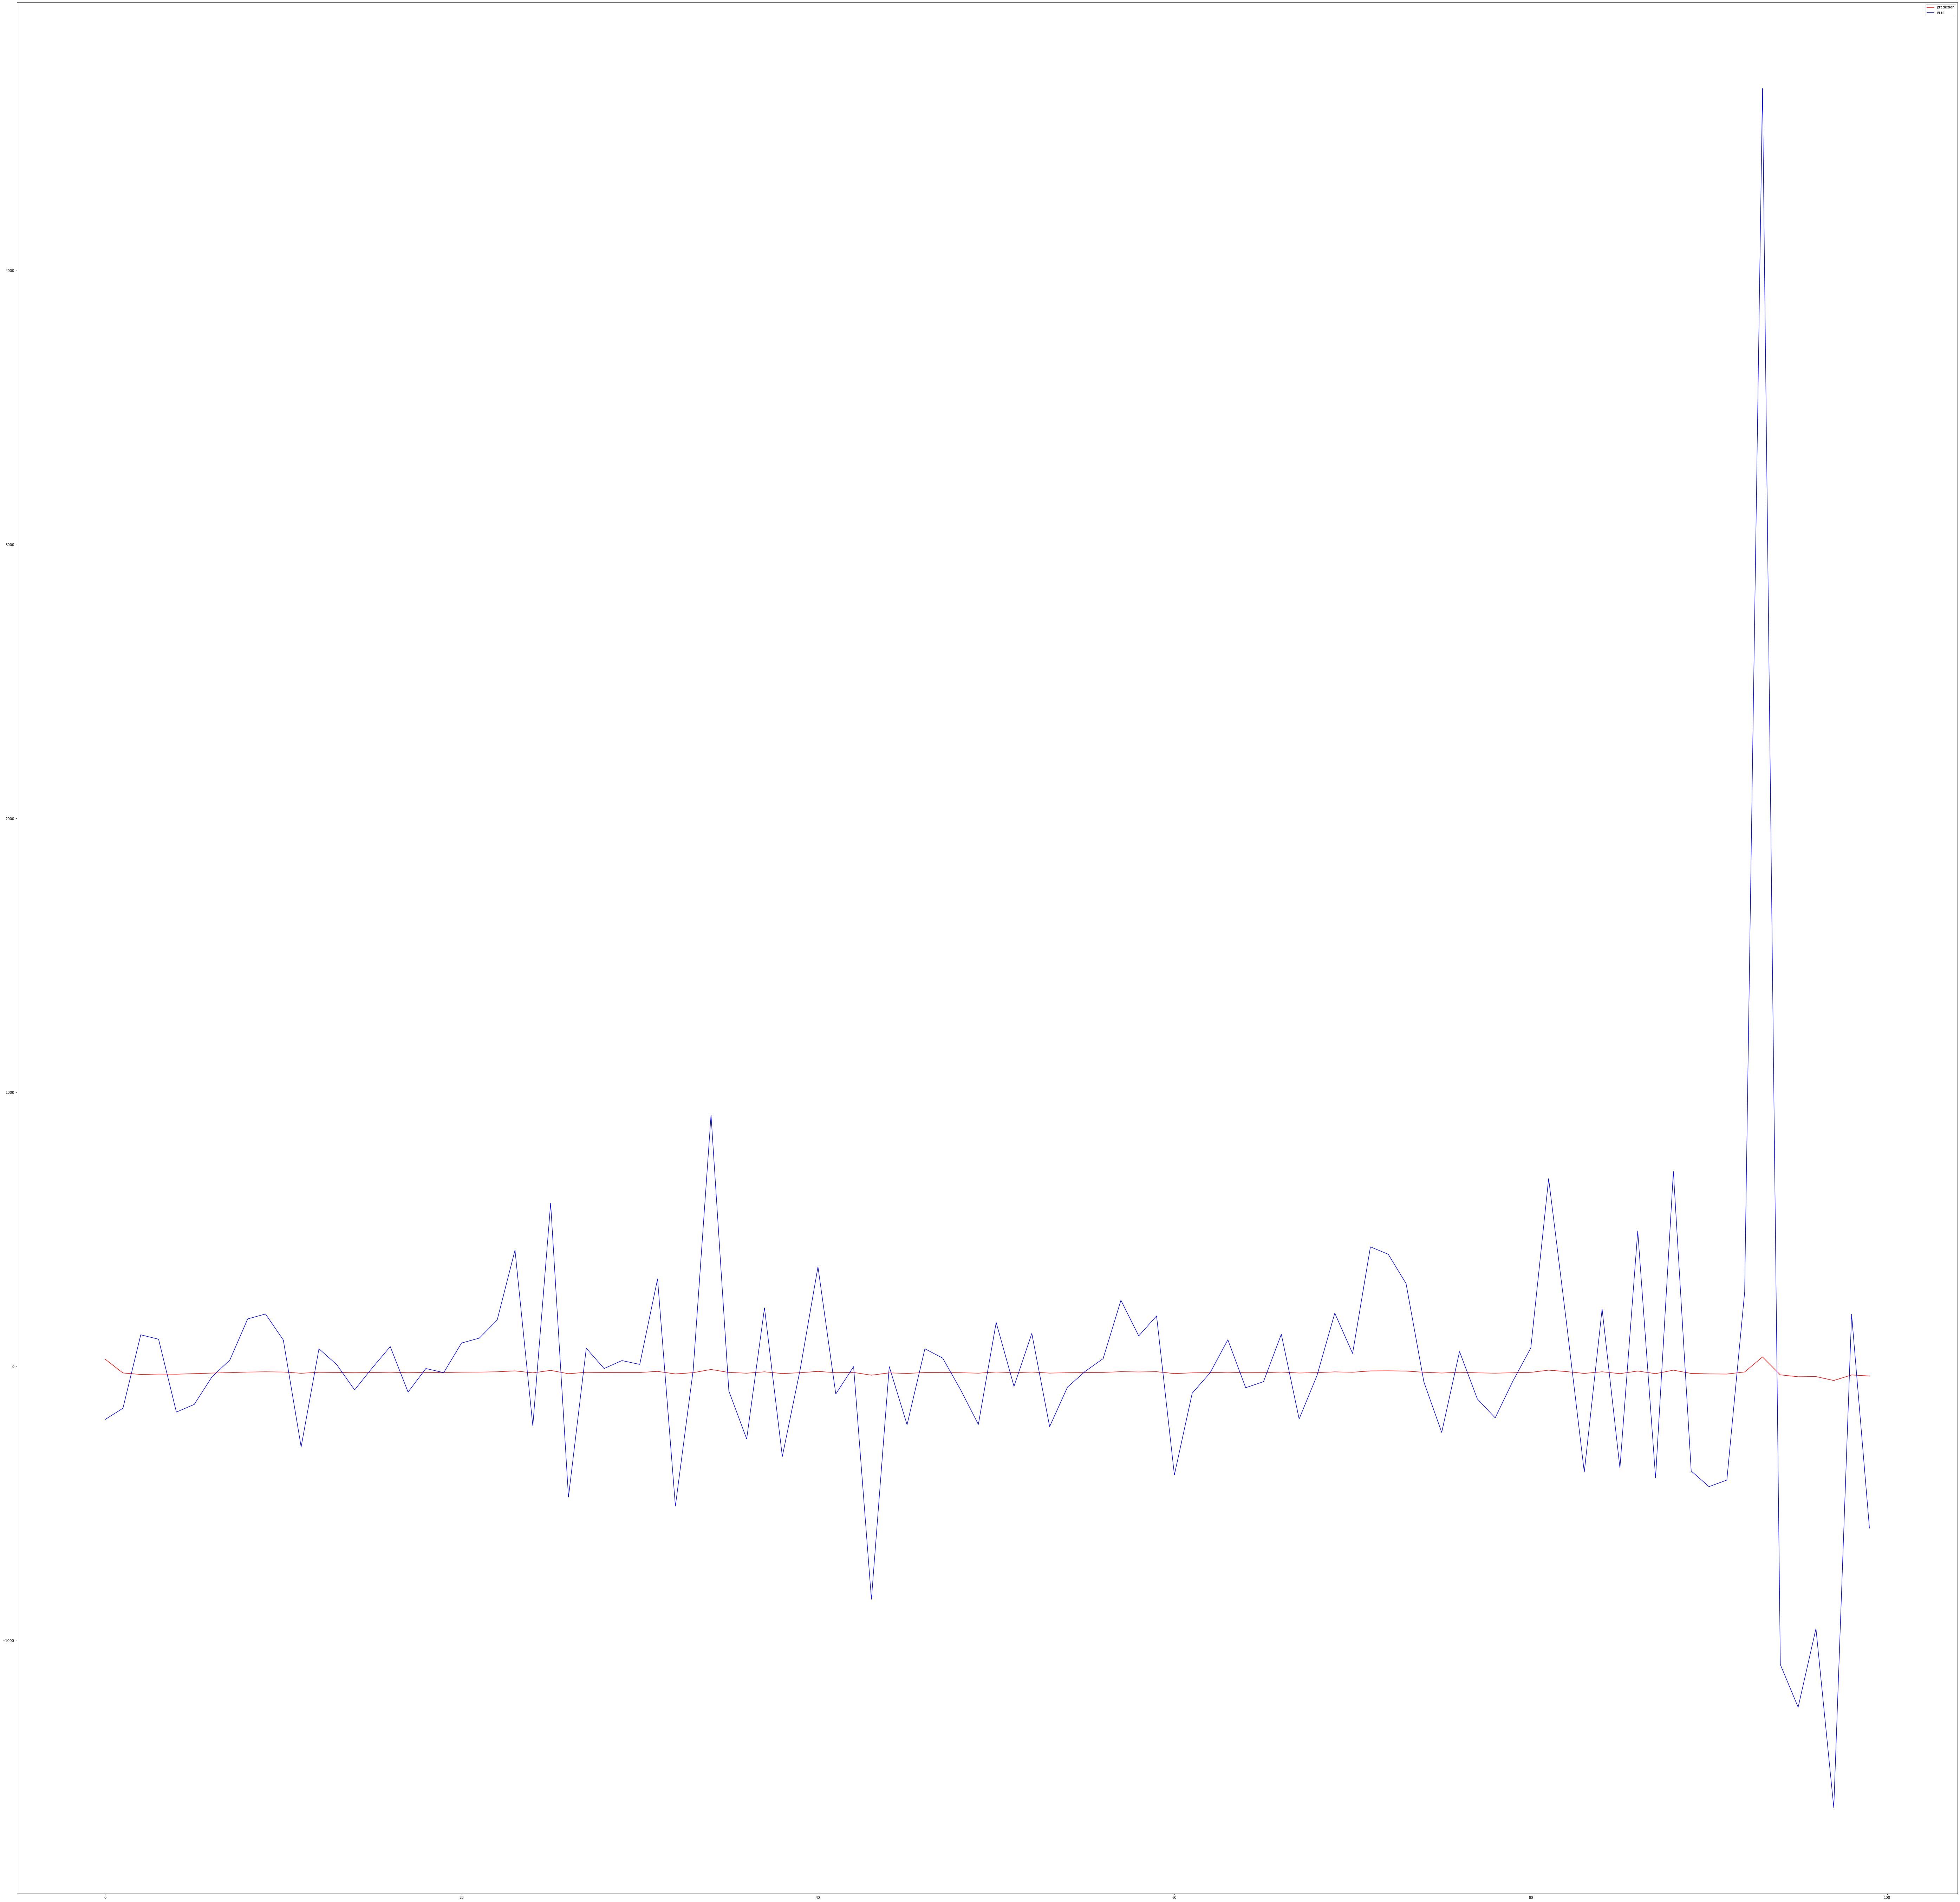

In [33]:
# In[ ]:

plt.figure(figsize=(99,99))

# plt.plot(pred_test, 'r', label='prediction')
# plt.plot( dataY[:train_size], 'b', label='real')
plt.plot(pred[:100], 'r', label='prediction')
plt.plot( real[:100], 'b', label='real')
plt.legend(loc='best')
plt.show()


# In[ ]: